# Exploring a Direct-Marketing Data Set
## (Uses code from Kevin L. Davenport and Sebastian Raschka)
=================================

In [22]:
# Import packages
import time
import csv
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
from tabulate import *

In [2]:
# Import SciKit Learn packages
from sklearn import model_selection #where the cross_validation and learning_curve modules live
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [3]:
%matplotlib inline

In [4]:
%%html
<!-- make markdown table pretty -->
<style>table {float:left}</style>

## Get the Data

In [5]:
# Load the data
# This is the Bank Marketing data set at the UCI Machine Learning Repository
# archive.ics.uci.edu/ml/datasets/Bank+Marketing
import os
data = pd.read_csv(os.getcwd() + '/Data/bank-additional/bank-additional-full.csv', sep=';')

In [6]:
# data sanity check -- go ahead and scroll to the right to see the complete table.
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
data.shape

(41188, 21)

## What the Data Attributes Mean

**Bank Client Data**

* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone') 
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

** Other Attributes**

* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Social and Economic Context Attributes**

* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output Variable (Desired Target)**

* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## Rename Columns as Needed

In [8]:
# Rename the economic and social indicator columns -- they contain dots in their names and are a pain to work with
data = data.rename(columns={'emp.var.rate': 'emp_var_rate', 'cons.price.idx': 'cons_price_idx', 'cons.conf.idx': 'cons_conf_idx', 'nr.employed': 'nr_employed'})
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [23]:
# Here are all the column names in the dataset
list(data)

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

## Check for Missing Data and Handle as Needed

In [88]:
# First we'll see if there are missing values -- always a good thing to check.
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

That's nice! There are no missing values. So now let's handle the categorical attributes which all happen to be nominal variables -- i.e., they have no natural ordering or ranking.
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- day_of_week
- poutcome

When attributes are ordinal, we can use mapping or label encoding to turn the text attribute values into numerical attribute values. But when the attributes are nominal, it's best to use *one-hot encoding*. We'll get to that later.

If we had missing data, there are a number of ways to handle that.

## Convert the Outcome Variable into Numerical Values (as needed)

In [24]:
# The last column contains info on whether the person bought the product or not
# The outcomes in the raw data are labeled 'yes' and 'no'.
# Change them into numerical outcomes -- 0 for no and 1 for yes
y = pd.Series([0 if val == 'no' else 1 for val in data.iloc[:,-1]])

In [10]:
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

# Visualize

In any data set like this one, there are many questions to ask. Does persistence on the part of the salesperson make a difference? When does persistence pay off and when does it backfire? Does the day of the week on which the final call is made make a difference to those who bought? And there are many many more.

Perhaps you can read off from the plots below, things like:
- If a person already has a loan, then persistence doesn't pay off (first row, second column)
- Most people who have a loan buy after at most 3 calls (row 2, column 2)
- If the prospect's loan status is not known, then don't all more than 5 times -- it's a waste. (row 2, column 3)
- In general, it's never a good idea to call more than 10 times. Stop and regroup. (All plots)

### Facet Plots

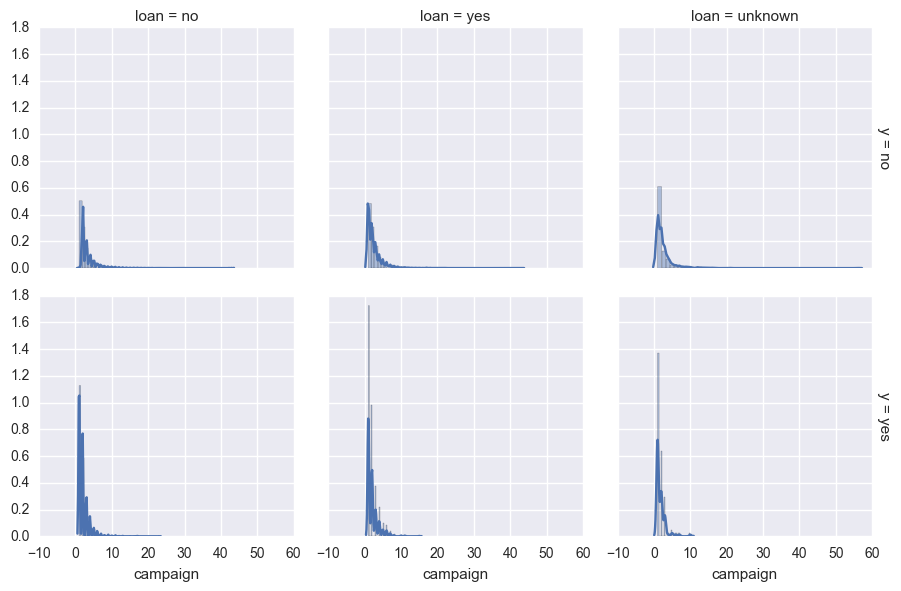

In [11]:
g = sns.FacetGrid(data, row='y', col='loan', margin_titles=True)
g.map(sns.distplot, 'campaign')

### Density Histograms

That's nice. And we can also look quickly to see whether a person buys or not depends on a characteristic they have. For example, in the plot below, we see if there's a difference in age between those who buy and those who don't.

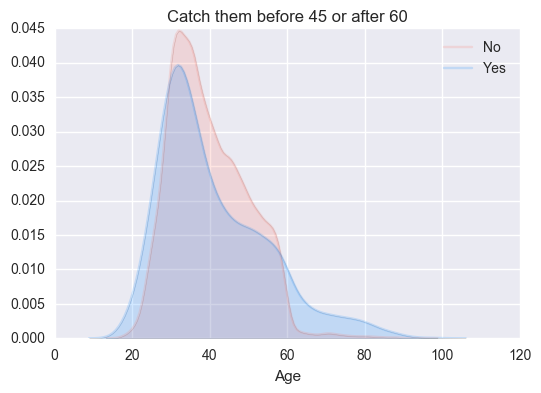

In [12]:
sns.kdeplot(data.query("y == 'no'").age, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").age, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title('Catch them before 45 or after 60')
plt.xlabel('Age')

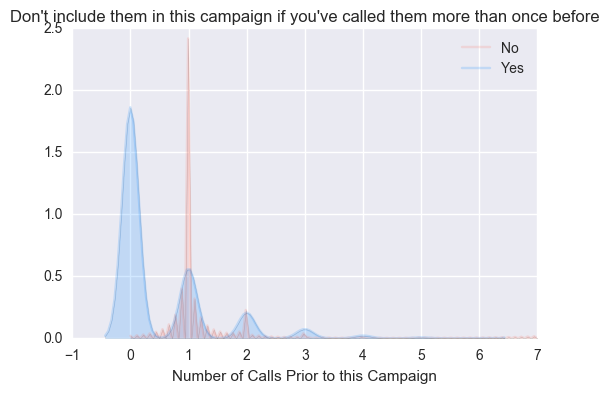

In [13]:
sns.kdeplot(data.query("y == 'no'").previous, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").previous, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Don't include them in this campaign if you've called them more than once before")
plt.xlabel('Number of Calls Prior to this Campaign')

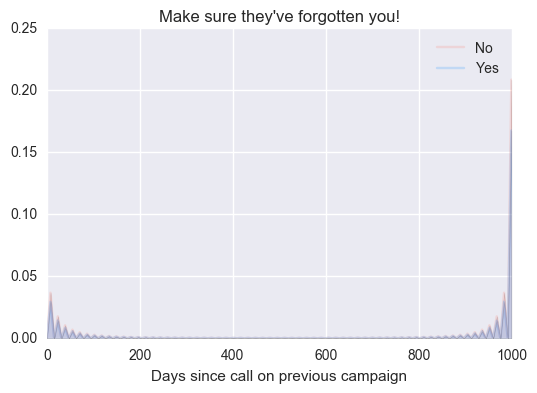

In [14]:
sns.kdeplot(data.query("y == 'no'").pdays, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").pdays, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Make sure they've forgotten you!")
plt.xlabel('Days since call on previous campaign')

How do economic variables affect buying behavior?

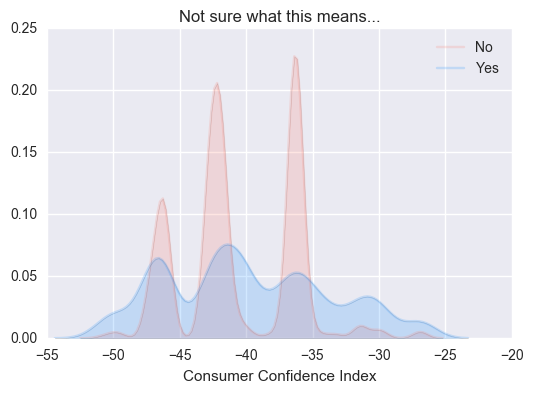

In [15]:
sns.kdeplot(data.query("y == 'no'").cons_conf_idx, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").cons_conf_idx, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Not sure what this means...")
plt.xlabel('Consumer Confidence Index')

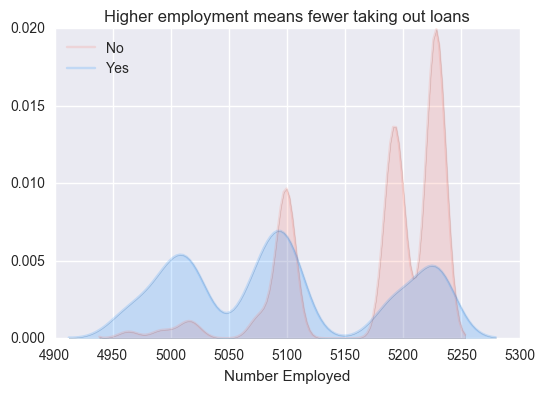

In [16]:
sns.kdeplot(data.query("y == 'no'").nr_employed, shade=True, alpha=0.2, label='No', color='salmon')
sns.kdeplot(data.query("y == 'yes'").nr_employed, shade=True, alpha=0.2, label='Yes', color='dodgerblue')
plt.title("Higher employment means fewer taking out loans")
plt.xlabel('Number Employed')

### Pivots

For attributes that are categorical we could see how buying behavior pans out.

In [17]:
# How poutcome -- whether the prospect has bought on the previous campaign -- influences buying behavior 
# in this campaign
gb_poutcome = data.groupby(by=['poutcome','y'])
gbs = gb_poutcome.size()
gbs

poutcome     y  
failure      no      3647
             yes      605
nonexistent  no     32422
             yes     3141
success      no       479
             yes      894
dtype: int64

Clearly, having bought before is a great indicator of whether a prospect will buy this time around.

In [18]:
# How day_of_week -- influences buying behavior 
gb_day = data.groupby(by=['day_of_week','y'])
gbs = gb_day.size()
gbs

day_of_week  y  
fri          no     6981
             yes     846
mon          no     7667
             yes     847
thu          no     7578
             yes    1045
tue          no     7137
             yes     953
wed          no     7185
             yes     949
dtype: int64

Call on Tuesdays, Wedenesdays, and Thursdays. Try having your best staff working on Mondays and Fridays and see if that makes any difference. 

In [19]:
# Does already having a loan influence buying behavior?
gb_loan = data.groupby(by=['loan','y'])
gbs = gb_loan.size()
gbs

loan     y  
no       no     30100
         yes     3850
unknown  no       883
         yes      107
yes      no      5565
         yes      683
dtype: int64

It's not clear just from the table above if already having a loan influences buying a new loan. How about if one has defaulted on a loan previously?

In [20]:
# Does defaulting on a loan influence buying behavior?
gb_default = data.groupby(by=['default','y'])
gbs = gb_default.size()
gbs

default  y  
no       no     28391
         yes     4197
unknown  no      8154
         yes      443
yes      no         3
dtype: int64

It's murky -- there doesn't seem to be enough data to tell one way or the other.

### Pairwise Scatter Plots

In [25]:
# Pairwise scatter plots of the campaign attributes (these features all have numeric values)
cols_campaign = ['age', 'duration', 'campaign', 'pdays', 'previous']

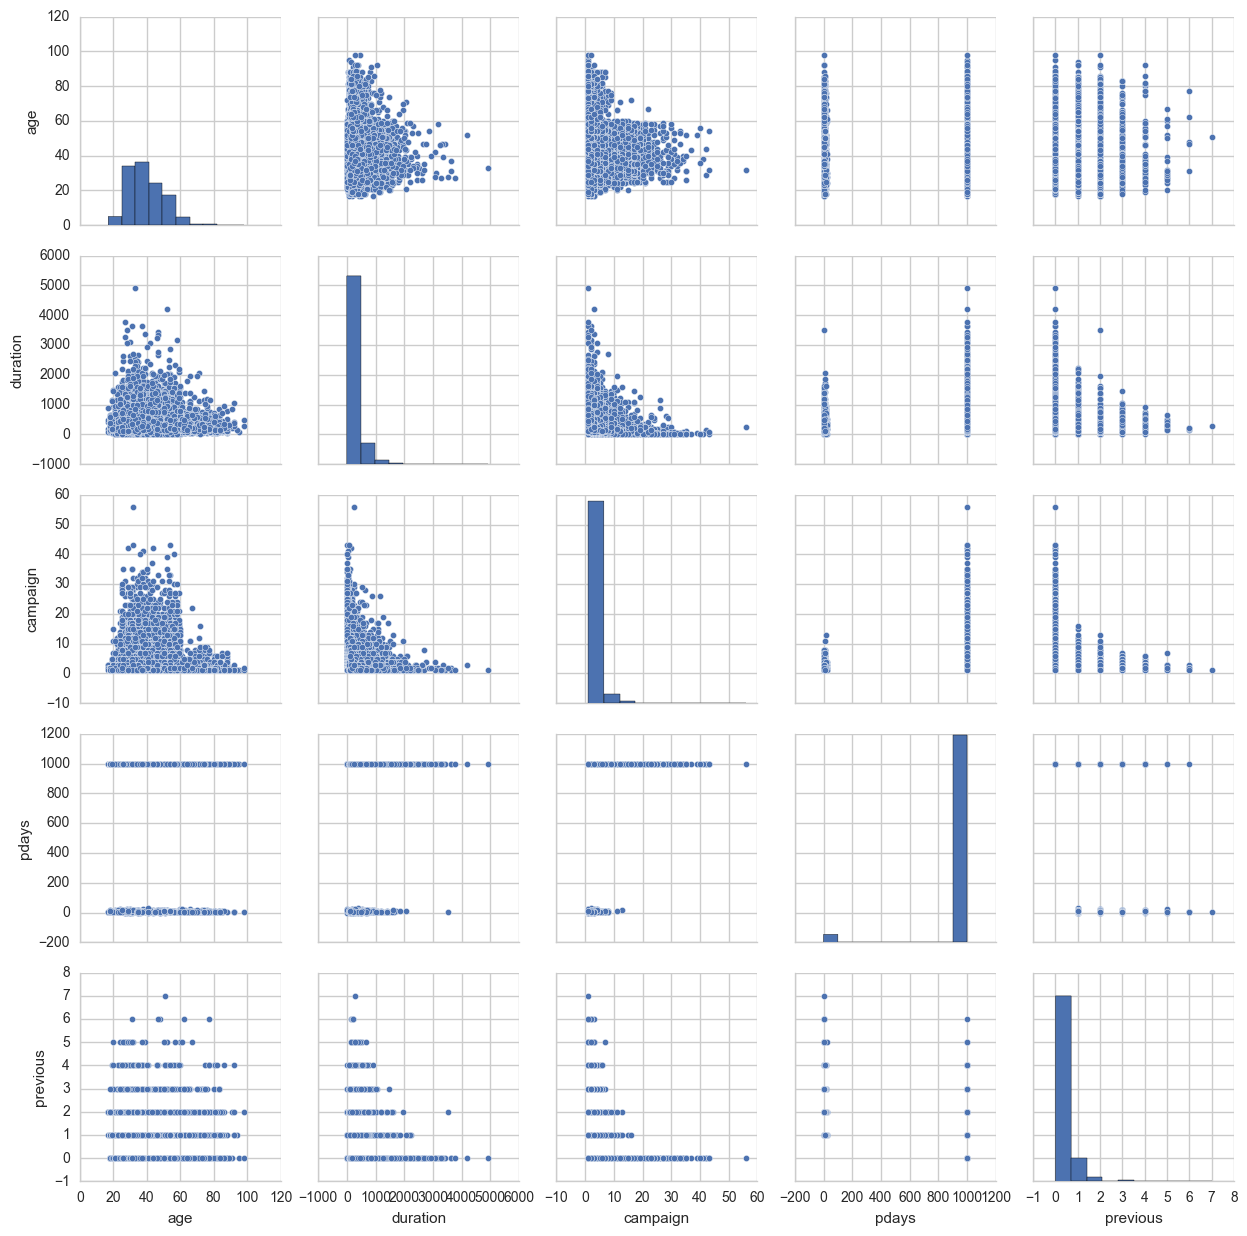

In [26]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(data[cols_campaign], size=2.5)

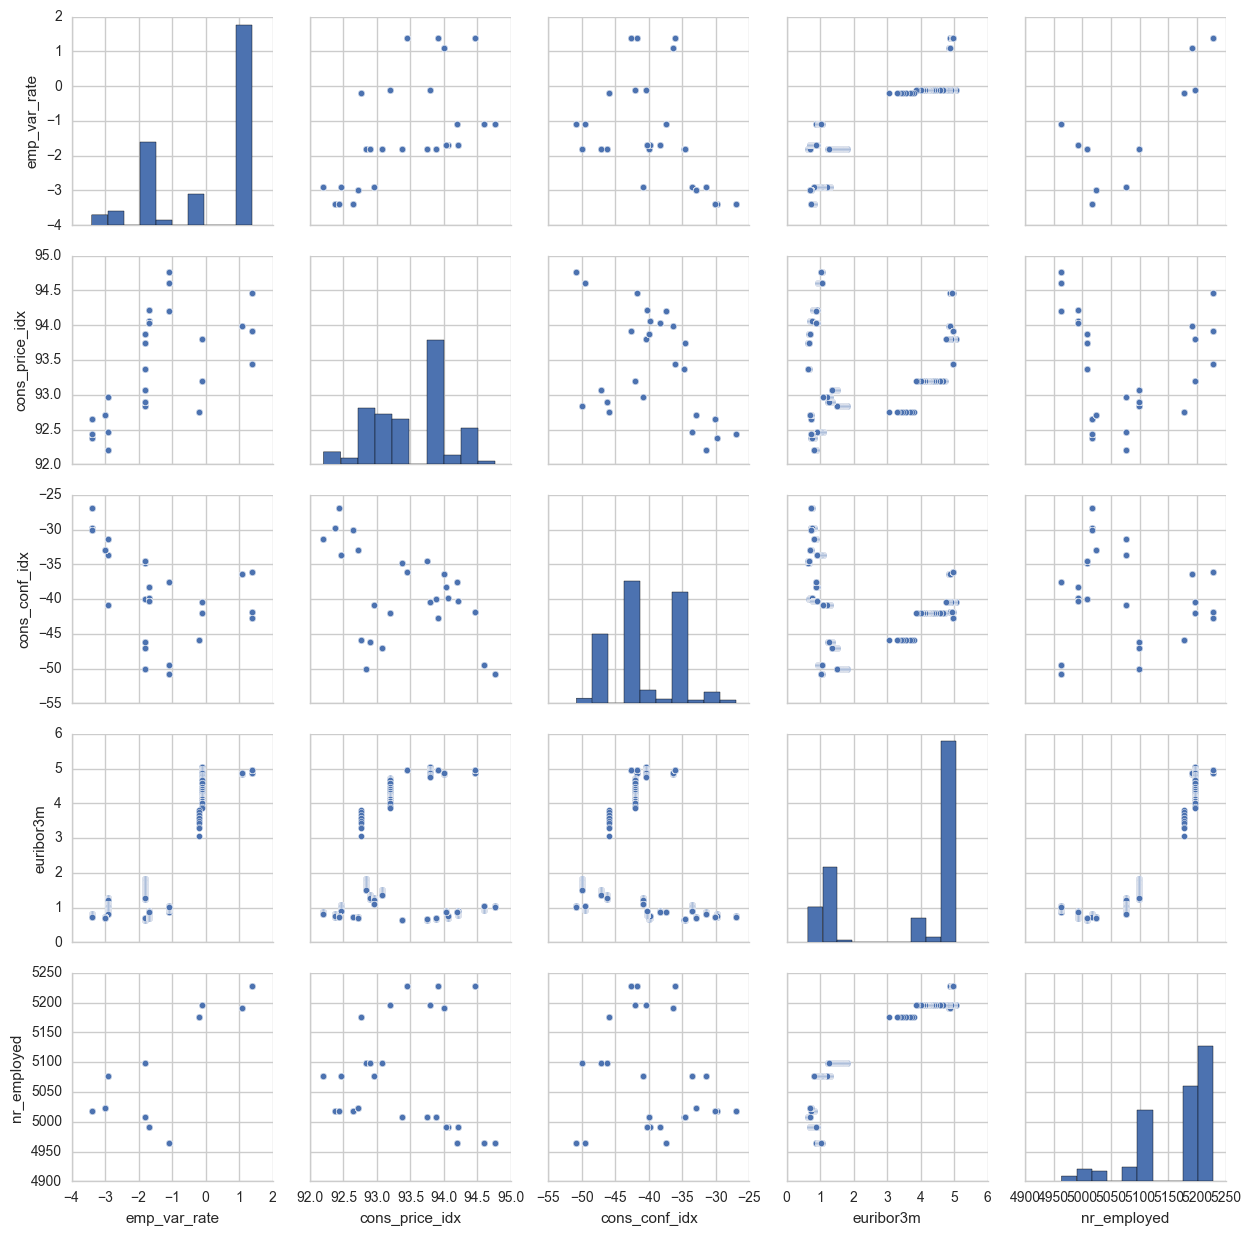

In [28]:
# Pairwise scatter plots of economic attributes (these features all have numeric values)
cols_econ = ['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
sns.pairplot(data[cols_econ], size=2.5)

And so it goes with just plain exploratory data analysis - sometimes things can jump out and surprise you. Other times not. It's an exploration after all. But there are some standard ways to visualize things -- let's recap.

1) Facet plots to see how outcome varies for continous-value features
2) Density histograms for how outcome varies for continuos-value features
3) Pivot tables to see how outcome varies for the discrete-value features
4) Scatter plots
5) Correlation matrices

The problem is none of these can give us anything definitive to say. They can give you directional guidance but can't really help if you're looking to make precise predictions. In the next chapter, we'll look 

## Looking at the Data as a Whole

So far so good. But this kind of exploration leads to the usual pesky questions of estimates and error and p-value and confidence level, and so on. Can we do better? Can we get away from the assumptions we need to get these types of estimates? Can we use the *complete* dataset to make some predictions?

And of course, when the number of features are in the 1000s or even in the millions -- quite typical for datasets used in machine learning -- it becomes untenable to do the kind of exploratory data analysis we did above.

So we'll have to use different techniques to make sense of whether and how the features are related to each other.

We can, but first we need to clean up the data and convert the categorical variables to numeric scales.

### One-Hot Encoding

In [106]:
# list(data) returns the column names as a list
# Pandas get_dummies automatically converts every categorical variable to an equivalent one-hot encoding
# We can do this for our dataset without hesitation because all our categorical variables are nominal 
# -- i.e., they don't have any rank ordering.
data2 = pd.get_dummies(data[list(data)])

In [107]:
data2.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Looks great except that we've one-hot encoded our outcome as well -- the dependent variable. Let's fix that.

In [108]:
data2['y'] = data2['y_yes'].map(lambda x: 1 if x > 0 else 0)
del data2['y_no']
del data2['y_yes']

In [109]:
data2.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


Ok, we're ready to do some feature selection and extraction. Check out: 
- http://machinelearningmastery.com/feature-selection-machine-learning-python/ (Jason Brownlee)
- http://scikit-learn.org/stable/modules/feature_selection.html (SciKit Learn documentation)
- http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline (SciKit Learn documentation)

for more ideas than what's covered below.

## Feature Selection/Reduction Techniques

### Removing features that have the same value for most rows in the dataset

As explained in the SciKit Learn documentation, "VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples."

Let's apply it to our dataset to see which features this might hold true of (if any).

In [111]:
data2.shape

(41188, 64)

In [113]:
data2.iloc[41187, :]

age                        74.000
duration                  239.000
campaign                    3.000
pdays                     999.000
previous                    1.000
emp_var_rate               -1.100
cons_price_idx             94.767
cons_conf_idx             -50.800
euribor3m                   1.028
nr_employed              4963.600
job_admin.                  0.000
job_blue-collar             0.000
job_entrepreneur            0.000
job_housemaid               0.000
job_management              0.000
job_retired                 1.000
job_self-employed           0.000
job_services                0.000
job_student                 0.000
job_technician              0.000
job_unemployed              0.000
job_unknown                 0.000
marital_divorced            0.000
marital_married             1.000
marital_single              0.000
marital_unknown             0.000
education_basic.4y          0.000
education_basic.6y          0.000
education_basic.9y          0.000
education_high

In [121]:
# Get the X and y matrices as arrays
cols = data2.shape[1]
X = data2.iloc[:, 0:cols-1].values
y = data2.iloc[:, cols-1].values

In [130]:
X[-10:-8,:]

array([[  6.20000000e+01,   4.83000000e+02,   2.00000000e+00,
          6.00000000e+00,   3.00000000e+00,  -1.10000000e+00,
          9.47670000e+01,  -5.08000000e+01,   1.03100000e+00,
          4.96360000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [128]:
y[-10:-5]

array([1, 0, 0, 1, 0])

In [136]:
from sklearn.feature_selection import VarianceThreshold
# Remove any feature that is the same value in 80% or more of the dataset
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
selector.fit_transform(X)

array([[  56.,  261.,    1., ...,    1.,    1.,    0.],
       [  57.,  149.,    1., ...,    1.,    1.,    0.],
       [  37.,  226.,    1., ...,    1.,    1.,    0.],
       ..., 
       [  56.,  189.,    2., ...,    0.,    0.,    0.],
       [  44.,  442.,    1., ...,    0.,    0.,    0.],
       [  74.,  239.,    3., ...,    0.,    0.,    0.]])

In [149]:
idx_features_selected = selector.get_support(indices=True)
print features_selected

[ 0  1  2  3  4  5  6  7  8  9 10 11 23 24 29 32 34 35 37 39 43 44 51 56 57]


In [154]:
# Get all the column names in our dataset *except* for the outcome variable name
col_names = list(data2.columns.values)[0:-1]

In [156]:
names_features_selected = [col_names[i] for i in idx_features_selected]

In [157]:
# Features not selected because they are the same value for more than 80% of the dataset
names_features_not_selected = list(set(col_names) - set(names_features_selected))
names_features_not_selected

['education_professional.course',
 'job_management',
 'marital_unknown',
 'job_student',
 'job_services',
 'education_basic.9y',
 'marital_divorced',
 'job_unemployed',
 'month_sep',
 'education_basic.4y',
 'poutcome_failure',
 'poutcome_nonexistent',
 'job_housemaid',
 'loan_unknown',
 'job_entrepreneur',
 'day_of_week_tue',
 'job_unknown',
 'month_mar',
 'poutcome_success',
 'loan_yes',
 'job_technician',
 'month_nov',
 'month_oct',
 'housing_unknown',
 'job_retired',
 'month_jun',
 'job_self-employed',
 'education_basic.6y',
 'month_jul',
 'day_of_week_fri',
 'month_aug',
 'education_unknown',
 'month_dec',
 'day_of_week_wed',
 'default_yes',
 'education_illiterate',
 'month_apr',
 'loan_no']

We could do away with these features to make our dataset more manageable.